# **Libraries**

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer # To handle potential missing values
import numpy as np # Often useful for handling numerical data
import matplotlib.pyplot as plt
import seaborn as sns

# **File Path**

In [2]:
# file_path = r"F:\University\Uni Stuff (semester 11)\Thesis\code\data\raw\thesis_data_updated.csv"
file_path = r"F:\University\Uni Stuff (semester 11)\Thesis\data\acled_aggregated_20198.csv"

# **Dataset**

In [3]:
df = pd.read_csv(file_path, parse_dates=['Event week'])

#  **Exploratory  Data Analysis**

In [4]:
df.head(10)

,Location,Event week,Event Type,Events
0,Munshiganj,2024-04-13,Battles,1
1,Munshiganj,2024-04-13,Riots,0
2,Munshiganj,2024-04-13,Violence against civilians,0
3,Munshiganj,2024-04-13,Explosions/Remote violence,0
4,Munshiganj,2024-04-13,Protests,0
5,Ruma,2024-04-13,Battles,1
6,Ruma,2024-04-13,Riots,0
7,Ruma,2024-04-13,Violence against civilians,0
8,Ruma,2024-04-13,Explosions/Remote violence,0
9,Ruma,2024-04-13,Protests,0


In [5]:
print(df.info())
print(df.describe)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152620 entries, 0 to 152619
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Location    152620 non-null  object        
 1   Event week  152620 non-null  datetime64[ns]
 2   Event Type  152620 non-null  object        
 3   Events      152620 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 4.7+ MB
None
<bound method NDFrame.describe of           Location Event week                  Event Type  Events
0       Munshiganj 2024-04-13                     Battles       1
1       Munshiganj 2024-04-13                       Riots       0
2       Munshiganj 2024-04-13  Violence against civilians       0
3       Munshiganj 2024-04-13  Explosions/Remote violence       0
4       Munshiganj 2024-04-13                    Protests       0
...            ...        ...                         ...     ...
152615     Noamala 2025-04

In [6]:
df.dtypes

Location              object
Event week    datetime64[ns]
Event Type            object
Events                 int64
dtype: object

In [7]:
print(df.isnull().sum())

Location      0
Event week    0
Event Type    0
Events        0
dtype: int64


In [8]:
# df['Crime_date'] = pd.to_datetime(df['Crime_date'])
# df['Crime_time'] = pd.to_datetime(df['Crime_time'], format='%I:%M:%S %p')

# **Visualizations**

In [9]:
# Frequency of Events
group_event_counts = df.groupby('Event Type')
total_counts = group_event_counts['Events'].sum()
print("--- Sum of Event Counts per Event Type ---")
print(total_counts)
print("\n--- Count of Event Types ---")
print(df['Event Type'].value_counts())

--- Sum of Event Counts per Event Type ---
Event Type
Battles                        38
Explosions/Remote violence      6
Protests                        6
Riots                         906
Violence against civilians    254
Name: Events, dtype: int64

--- Count of Event Types ---
Event Type
Battles                       30524
Riots                         30524
Violence against civilians    30524
Explosions/Remote violence    30524
Protests                      30524
Name: count, dtype: int64


In [10]:
# Frequency of Event Locations
group_location_counts = df.groupby('Location')
location_counts = group_location_counts['Events'].sum()
print("\n--- Sum of Event Counts per Location ---")
print(location_counts)
print("\n--- Count of Event Locations ---")
print(df['Location'].value_counts())


--- Sum of Event Counts per Location ---
Location
Abhaynagar    3
Aditmari      1
Ahmmadpur     1
Akcha         2
Akhanagar     1
             ..
Vikakhali     1
Walapalong    1
Wazirpur      2
Whykong       3
Zajira        2
Name: Events, Length: 587, dtype: int64

--- Count of Event Locations ---
Location
Munshiganj        260
Tetuljhora        260
Naikhongchhari    260
Singra            260
Jaintiapur        260
                 ... 
Barandi           260
Barisal           260
Basan             260
Basurhat          260
Noamala           260
Name: count, Length: 587, dtype: int64


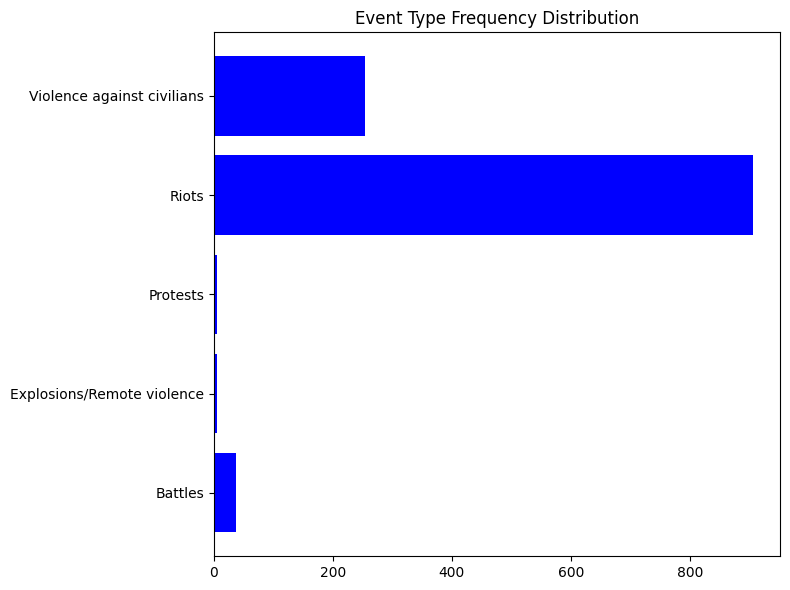

In [11]:
# Frequency distribution of Event Type
x = total_counts.index
y = total_counts.values
plt.figure(figsize=(8, 6))
plt.title('Event Type Frequency Distribution')
plt.barh(x, y, color='blue')
plt.tight_layout()
plt.show()

#  **Preprocessing**

In [14]:
pre_processed_df = df.copy()
pre_processed_df.sort_values(by='Event week', inplace=True)

In [ ]:
# pre_processed_df = pre_processed_df.drop(columns='SL')

In [ ]:
print(pre_processed_df.head())
print(pre_processed_df.info())
print(pre_processed_df.isnull().sum())

     Location Event week                  Event Type  Events
0  Munshiganj 2024-04-13                     Battles       1
1  Munshiganj 2024-04-13                       Riots       0
2  Munshiganj 2024-04-13  Violence against civilians       0
3  Munshiganj 2024-04-13  Explosions/Remote violence       0
4  Munshiganj 2024-04-13                    Protests       0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152620 entries, 0 to 152619
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Location    152620 non-null  object        
 1   Event week  152620 non-null  datetime64[ns]
 2   Event Type  152620 non-null  object        
 3   Events      152620 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 4.7+ MB
None
Location      0
Event week    0
Event Type    0
Events        0
dtype: int64


In [17]:
def impute_missing_weeks(df, start_date: str, end_date: str) -> pd.DataFrame:
    """
    Ensure each Location has a row for every week in the date range.
    Missing Event Count and Event Type get filled with zeros or 'None'.
    """
    # build full index of all location-week combinations
    all_locs = df['Location'].unique()
    full_weeks = pd.date_range(start=start_date, end=end_date, freq='W')
    idx = pd.MultiIndex.from_product([all_locs, full_weeks], names=['Location', 'Event Week'])

    # reindex and fill missing counts
    df_full = df.set_index(['Location', 'Event Week']).reindex(idx)
    df_full['Events'] = df_full['Events'].fillna(0)
    df_full['Event Type'] = df_full['Event Type'].fillna('None')
    df_full = df_full.reset_index()
    return df_full

def define_hotspot_label(df, window = 4, threshold_quantile = 0.8):
    """
    Compute a rolling window sum of Event Count and binarize into Hotspot vs. non-Hotspot.
    Threshold is the quantile of all rolling sums.
    """
    df = df.sort_values(['Location', 'Event Week'])
    df['rolling_sum'] = (
        df.groupby('Location')['Events']
          .transform(lambda x: x.rolling(window, min_periods=1).sum())
    )
    threshold = df['rolling_sum'].quantile(threshold_quantile)
    df['Hotspot'] = (df['rolling_sum'] >= threshold).astype(int)
    return df

def create_features(df):
    """
    Generate temporal and categorical features:
      - WeekOfYear, Month, Year
      - One-hot encode Event Type
      - Lagged rolling windows of counts
    """
    # Temporal
    df['WeekOfYear'] = df['Event Week'].dt.isocalendar().week
    df['Month']      = df['Event Week'].dt.month
    df['Year']       = df['Event Week'].dt.year

    # Categorical encoding
    df = pd.get_dummies(df, columns=['Event Type'], prefix='Type')

    # Lagged rolling sums
    for w in [1, 4, 12]:
        col_name = f'Count_last_{w}w'
        df[col_name] = (
            df.groupby('Location')['Events']
              .transform(lambda x: x.shift(1).rolling(w, min_periods=1).sum())
              .fillna(0)
        )
    return df

def preprocess(df, start_date: str, end_date: str) -> pd.DataFrame:
    """
    Full preprocessing pipeline:
      1. Impute missing weeks
      2. Define Hotspot label
      3. Create features
      4. Drop intermediate columns
    """
    df = impute_missing_weeks(df, start_date, end_date)
    df = define_hotspot_label(df)
    df = create_features(df)

    # Remove intermediate columns no longer needed for modeling
    df = df.drop(columns=['Event Count', 'rolling_sum'])
    return df

In [ ]:
preprocessed_df = preprocess(pre_processed_df, '2024-04-13', '2019-12-31')

In [ ]:
# pre_processed_df['GDP per capita (USD)'] = pre_processed_df['GDP per capita (USD)'].str.replace(',', '')

In [ ]:
# pre_processed_df['GNI per capita (USD)'] = pre_processed_df['GNI per capita (USD)'].str.replace(',', '')

In [ ]:
# pre_processed_df['GDP per capita (USD)'] = pd.to_numeric(pre_processed_df['GDP per capita (USD)'])
# pre_processed_df['GNI per capita (USD)'] = pd.to_numeric(pre_processed_df['GNI per capita (USD)'])

In [15]:
# Temporal features
pre_processed_df['month'] = pre_processed_df['Event week'].dt.month
pre_processed_df['day'] = pre_processed_df['Event week'].dt.day
pre_processed_df['year'] = pre_processed_df['Event week'].dt.year
# pre_processed_df['hour'] = pre_processed_df['Crime_time'].dt.hour
# pre_processed_df['minutes'] = pre_processed_df['Crime_time'].dt.minute
# pre_processed_df['crime_hour_sin'] = np.sin(2 * np.pi * pre_processed_df['hour'] / 24)
# pre_processed_df['crime_hour_cos'] = np.cos(2 * np.pi * pre_processed_df['hour'] / 24)

In [ ]:
# pre_processed_df.sort_values(by='Event week', inplace=True)
# pre_processed_df.drop(columns = ['Crime_date', 'Crime_time'], inplace=True)

# **Feature Engineering**

In [14]:
pre_processed_df = pd.get_dummies(pre_processed_df, columns=['gender'])

In [15]:
numerical_cols = pre_processed_df.select_dtypes(include=['float64', 'int64', 'int32', 'bool']).columns.tolist()
categorical_cols = pre_processed_df.select_dtypes(include=['object']).columns.tolist()
print("Numerical columns: ", numerical_cols)
print("Categorical columns: ", categorical_cols)

Numerical columns:  ['Age', 'month', 'day', 'year', 'hour', 'minutes', 'crime_hour_sin', 'crime_hour_cos', 'gender_female', 'gender_male']
Categorical columns:  ['PS/SD', 'Crime_Location', 'Allegation']


In [44]:
# Features and Target variable
target_column = 'Allegation'
y = pre_processed_df[target_column]
X = pre_processed_df.drop(columns=[target_column], axis=1)

print(f"\nFeatures (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")


Features (X) shape: (2081, 12)
Target (y) shape: (2081,)


In [66]:
# y_group = y.groupby(y).count()
# print(y_group)
allegation_counts = y.value_counts()
print(allegation_counts)

Allegation
mob attack                       385
Cocktail explosion               245
illegal arms                     245
attack                           236
illegal arms supply              229
arms supply                      156
explosive supply                 156
ordered to murder                156
theft                             40
half murder                       32
robbery                           29
life threat                       23
extortion                         20
murder                            19
Unlawful Assembly Membership      19
Collective Criminal Liability     19
delivering explosives             16
Illegal gatheringing              16
terror                            14
loss of value                      7
unethical gathering                7
death threat                       7
drugs                              5
Name: count, dtype: int64


In [47]:
# Encoding & Scaling
le = LabelEncoder()
scaler = StandardScaler()

y_encoded = le.fit_transform(y)
# X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# Check the mapping from labels to numbers
print("\nTarget Variable Encoding:")
for i, class_label in enumerate(le.classes_):
    print(f"{class_label} -> {i}")

X['PS/SD_encoded'] = le.fit_transform(X['PS/SD'])
X['Crime_Location_encoded'] = le.fit_transform(X['Crime_Location'])
# Freuency encoding for categorical features
# X['PS/SD_encoded'] = X.groupby('PS/SD')['PS/SD'].transform('count')
# X['Crime_Location_encoded'] = X.groupby('Crime_Location')['Crime_Location'].transform('count')
X.drop(columns=['PS/SD', 'Crime_Location'], inplace=True)


Target Variable Encoding:
Cocktail explosion -> 0
Collective Criminal Liability -> 1
Illegal gatheringing -> 2
Unlawful Assembly Membership -> 3
arms supply -> 4
attack -> 5
death threat -> 6
delivering explosives -> 7
drugs -> 8
explosive supply -> 9
extortion -> 10
half murder -> 11
illegal arms -> 12
illegal arms supply -> 13
life threat -> 14
loss of value -> 15
mob attack -> 16
murder -> 17
ordered to murder -> 18
robbery -> 19
terror -> 20
theft -> 21
unethical gathering -> 22


In [52]:
pca = PCA(n_components=0.95)  # Keep 95% of variance
X_pca = pca.fit_transform(X)
print(f"\nOriginal number of features: {X.shape[1]}")
print(f"Reduced number of features after PCA: {X_pca.shape[1]}")


Original number of features: 12
Reduced number of features after PCA: 3


In [ ]:
# le_ps = LabelEncoder()
# le_crime_location = LabelEncoder()
# X['PS/SD'] = le_ps.fit_transform(X['PS/SD'])
# X['Crime_Location'] = le_crime_location.fit_transform(X['Crime_Location'])
# # Check the mapping from labels to numbers
# print("\nPS/SD Encoding:")
# for i, class_label in enumerate(le_ps.classes_):
#     print(f"{class_label} -> {i}")

# print("\nCrime Location Encoding:")
# for i, class_label in enumerate(le_crime_location.classes_):
#     print(f"{class_label} -> {i}")

In [22]:
learned_classes = le.classes_
encoding_map = {label: index for index, label in enumerate(learned_classes)}
print("\nEncoding Map (Dictionary):")
print(encoding_map)


Encoding Map (Dictionary):
{'Cocktail explosion': 0, 'Cocktail explosion ': 1, 'Collective Criminal Liability': 2, 'Illegal gatheringing': 3, 'Unlawful Assembly Membership': 4, 'arms supply': 5, 'attack': 6, 'attack ': 7, 'death threat': 8, 'delivering explosives': 9, 'drugs': 10, 'explosive supply ': 11, 'extortion ': 12, 'half murder': 13, 'half murder ': 14, 'illegal arms': 15, 'illegal arms supply': 16, 'life threat': 17, 'loss of value ': 18, 'mob attack': 19, 'mob attack ': 20, 'murder': 21, 'murder ': 22, 'ordered to murder ': 23, 'robbery': 24, 'robbery ': 25, 'terror': 26, 'theft': 27, 'theft ': 28, 'unethical gathering ': 29}


# **Train Test Split**

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
print(f"\nTraining features shape: {X_train.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Testing target shape: {y_test.shape}")


Training features shape: (1664, 12)
Testing features shape: (417, 12)
Training target shape: (1664,)
Testing target shape: (417,)


In [ ]:
# X_train_scaled = scaler.fit_transform(X_train)

# **Training and Evaluation**

In [57]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(f"\nPredictions shape: {y_pred.shape}")


Predictions shape: (417,)


In [59]:
# Decode the predicted numerical labels back to original allegation names for clarity
y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test) # Decode test labels for comparison

print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred_labels, target_names=le.classes_))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_labels, y_pred_labels, labels=le.classes_))
print("\nAccuracy Score:")
print(accuracy_score(y_test_labels, y_pred_labels))
# Plotting the confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=le.classes_)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

ValueError: y contains previously unseen labels: [ 9 10 11 12 13 14 15 17 18 19 20 22]